In [29]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score,BinaryF1Score,BinaryAccuracy,BinaryConfusionMatrix
import torch.optim.lr_scheduler as lr_scheduler 


# Data 및 시각화 관련
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
class make_dataset(Dataset):
    def __init__(self,featureDF,targetDF) -> None:
        super().__init__()
        # self.DF = DF
        self.targetDF = targetDF
        self.featureDF = featureDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values).to(self.device)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values).to(self.device)

        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [31]:
class dynamic_bcf_Model(nn.Module):
    # 모델구조 구성 및 인스턴스 생성 메서드
    def __init__(self,in_in,* in_out):
        super().__init__()
        self.in_layer = nn.Linear(in_in,in_out[0])
        self.h_layer = nn.ModuleList([nn.Linear(in_out[i],in_out[i+1]) for i in range(len(in_out)-1)])
        self.out_layer = nn.Linear(in_out[-1],1)

    # 순방향 학습 진행 메서드
    def forward(self,x):
        y=self.in_layer(x)      # f1w1 + f2w2 + f3w3 + b 결과 10
        y=F.relu(y)             # 0 <= y
        for layer in self.h_layer:
            y=layer(y)
            y=F.relu(y)
        return F.sigmoid(self.out_layer(y))  

In [32]:
mbti_df=pd.read_csv('../data/MBTI.csv')
mbti_df

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


In [33]:
sampled_df = mbti_df.groupby('type', group_keys=False).apply(lambda x: x.sample(n=60, random_state=1))
sampled_df['type'].value_counts()

type
ENFJ    60
ENFP    60
ENTJ    60
ENTP    60
ESFJ    60
ESFP    60
ESTJ    60
ESTP    60
INFJ    60
INFP    60
INTJ    60
INTP    60
ISFJ    60
ISFP    60
ISTJ    60
ISTP    60
Name: count, dtype: int64

In [34]:
feature_df=sampled_df['posts']

In [35]:
target_df=sampled_df['type'].str.contains('E')
target_df

53640     True
54635     True
53847     True
53691     True
54304     True
         ...  
50725    False
52006    False
50163    False
52683    False
52551    False
Name: type, Length: 960, dtype: bool

In [36]:
#E=0, I=1
target_df=np.array(target_df.astype('int8'))

In [37]:
#문자열 데이터를 벡터화
vectorizer = TfidfVectorizer(max_features=1200,min_df=5)
vectorizer = vectorizer.fit(sampled_df['posts'].to_numpy().reshape(-1))

In [38]:
vds = []
vts = []
for i,e in enumerate(feature_df.to_numpy()):
    dataStr = e.split(' ')
    npStr = np.array(dataStr).reshape(-1)
    for v in vectorizer.transform(npStr).toarray():
        vds.append(v)
        vts.append(target_df[i])

In [11]:
feature_df=pd.DataFrame(vds)
target_df=pd.DataFrame(vts)

In [12]:
print(feature_df.shape,feature_df.ndim)
print(target_df.shape,target_df.ndim)

(480864, 1200) 2
(480864, 1) 2


In [13]:
x_train, x_test, y_train, y_test = train_test_split(feature_df,target_df,stratify=target_df, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,stratify=y_train, test_size=0.2, random_state=1)

In [14]:
model=dynamic_bcf_Model(1200,900,800,700,600,500,400,300,200,100,80,75,50,25,15,10,5)
print(model)

dynamic_bcf_Model(
  (in_layer): Linear(in_features=1200, out_features=900, bias=True)
  (h_layer): ModuleList(
    (0): Linear(in_features=900, out_features=800, bias=True)
    (1): Linear(in_features=800, out_features=700, bias=True)
    (2): Linear(in_features=700, out_features=600, bias=True)
    (3): Linear(in_features=600, out_features=500, bias=True)
    (4): Linear(in_features=500, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=300, bias=True)
    (6): Linear(in_features=300, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=100, bias=True)
    (8): Linear(in_features=100, out_features=80, bias=True)
    (9): Linear(in_features=80, out_features=75, bias=True)
    (10): Linear(in_features=75, out_features=50, bias=True)
    (11): Linear(in_features=50, out_features=25, bias=True)
    (12): Linear(in_features=25, out_features=15, bias=True)
    (13): Linear(in_features=15, out_features=10, bias=True)
    (14): Linear(in_feature

In [24]:
x_train.shape[0]/500

615.504

In [25]:
train_ds=make_dataset(x_train,y_train)
val_ds=make_dataset(x_val,y_val)
test_ds=make_dataset(x_test,y_test)

train_dl=DataLoader(train_ds,batch_size=x_train.shape[0]//500)

for feature,target in train_dl:
    print(feature.shape,target.shape, feature,target)
    break

torch.Size([615, 1200]) torch.Size([615, 1]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
 

In [26]:
optimizer=optim.Adam(model.parameters(),lr=0.001)

scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=10,verbose=True)

binary_loss=nn.BCELoss()

In [27]:
loss_history=[[],[]]
score_history=[[],[]]

EPOCH=100

for epoch in range(EPOCH):
    model.train()

    total_loss=0
    total_score=0

    for feature, target in train_dl:
        #학습 진행
        pre_y=model(feature)

        #손실 계산
        loss=binary_loss(pre_y,target)
        total_loss+=loss.item()

        #성능평가
        score=BinaryF1Score()(pre_y,target)
        total_score+=score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증
    model.eval()

    with torch.no_grad():
        #검증데이터셋
        val_feature=val_ds[:][0]
        val_target=val_ds[:][1]

        #평가
        pre_val=model(val_feature)

        #손실
        loss_val=binary_loss(pre_val,val_target)
        
        #성능평가
        score_val=BinaryF1Score()(pre_val,val_target)

    # 손실값과 성능값 저장
    loss_history[0].append(total_loss/len(train_dl))
    score_history[0].append(total_score/len(train_dl))

    loss_history[1].append(loss_val)
    score_history[1].append(score_val)

    print(f'[{epoch+1}/{EPOCH}]\n- Train Loss : {loss_history[0][-1]} Score : {score_history[0][-1]}')
    print(f'- Val Loss : {loss_history[1][-1]} Score : {score_history[1][-1]}')

    #최적화 스케줄러 인스턴스 업데이트
    scheduler.step(loss_val)
    print(f'scheduler.num_bad_epochs: {scheduler.num_bad_epochs}',end=' ')
    print(f'scheduler.patience: {scheduler.patience}')

    #손실 감소(성능 개선) 안 되는 경우 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'{scheduler.patience} EPOCH 성능 개선 없어서 조기 종료')
        break

[1/1000]
- Train Loss : 0.6931500256418468 Score : 0.4893268052927272
- Val Loss : 0.6931465268135071 Score : 0.6674922108650208
scheduler.num_bad_epochs: 0 scheduler.patience: 100
[2/1000]
- Train Loss : 0.693149288971267 Score : 0.4879889404940272
- Val Loss : 0.6931466460227966 Score : 0.6674922108650208
scheduler.num_bad_epochs: 1 scheduler.patience: 100
[3/1000]
- Train Loss : 0.693149188440479 Score : 0.4879889404940272
- Val Loss : 0.693146824836731 Score : 0.6674922108650208
scheduler.num_bad_epochs: 2 scheduler.patience: 100
[4/1000]
- Train Loss : 0.6931491048036221 Score : 0.4879172710839384
- Val Loss : 0.6931469440460205 Score : 0.6674922108650208
scheduler.num_bad_epochs: 3 scheduler.patience: 100
[5/1000]
- Train Loss : 0.6931490240220776 Score : 0.4879172710839384
- Val Loss : 0.6931470036506653 Score : 0.6674922108650208
scheduler.num_bad_epochs: 4 scheduler.patience: 100
[6/1000]
- Train Loss : 0.6931489704849715 Score : 0.4879172710839384
- Val Loss : 0.6931472420692

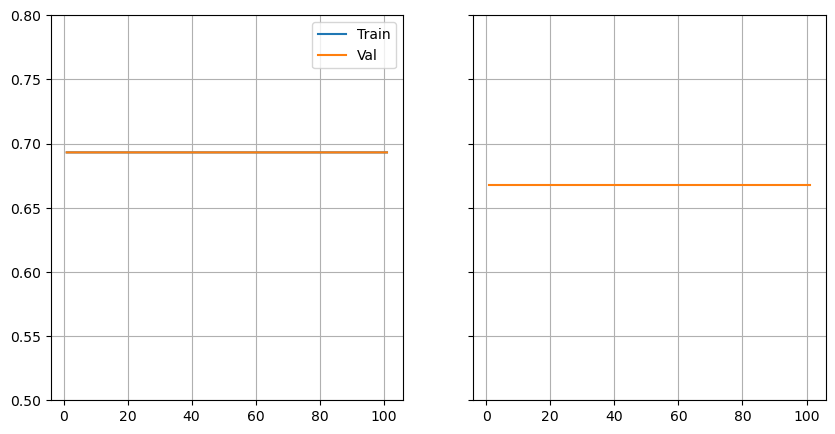

In [28]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화

th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Val')
axes[0].set_ylim([0.5,0.8])
axes[0].grid()
axes[0].legend()

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Val')
axes[1].grid()

axes[1].legend

plt.show()